In [1]:
## Collaborative Filtering
from nltk.stem.porter import PorterStemmer
import json
import re
import math
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## create a dictionary of user: user_id --> user_name
dictUser = {}
with open('yelp_data/yelp_academic_dataset_user.json') as f:
    for line in f:
        temp = json.loads(line)        
        dictUser[temp["user_id"]] = temp["name"]
        
print "done"

done


In [27]:
## create a dictionary of business: business_id --> restaurant
dictBusiness = {}
with open('yelp_data/yelp_academic_dataset_business.json') as f:
    for line in f:
        temp = json.loads(line)        
        dictBusiness[temp["business_id"]] = temp["name"]
        
print "done"

done


In [4]:
## objectives (2)
## 1. get the number of users & items in training data (currently with size of 40,000)
## 2. get Global: mu, bias_user, bias_item

# get the size of user_id & business_id
user_id = []
business_id = []
index = 0
# with open('yelp_data/average_accuracy.json') as f:
with open('yelp_data/refine_training_set.json') as f:
    for line in f:
        temp = json.loads(line)        
        user_id.append(temp["user_id"])
        business_id.append(temp["business_id"])
        
print user_id.__len__()
print business_id.__len__()

# This is without duplication: set
user_id = set(user_id)
business_id = set(business_id)

print user_id.__len__()
print business_id.__len__()
print "done"

253093
253093
21752
12540
done


In [5]:
# calculate the Global bias
# initialize the dictionary:
#   average --> global average
#   user_bias_list = {user_id --> a list of scores}
#   business_bias_list = {business_id --> a list of scores}
average = 0
num_star = 0
user_bias_list = {}
origin_user_bias = {}
business_bias_list = {}
origin_business_bias = {}
for value in user_id:
    user_bias_list[value] = []
    origin_user_bias[value] = 0
for value in business_id:
    business_bias_list[value] = []
    origin_business_bias[value] = 0

# adding the list
with open('yelp_data/refine_training_set.json') as f:
# with open('yelp_data/average_accuracy.json') as f:
    for line in f:
        # get the infor from file
        temp = json.loads(line)        
        cur_user_id = temp["user_id"]
        cur_business_id = temp["business_id"]
        star = temp["stars"]
        # filling the dictionary & calculate the average
        average += star
        num_star += 1
        user_bias_list[cur_user_id].append(star)
        business_bias_list[cur_business_id].append(star)

# average
average /= float(num_star)
# calculate: user_bias = {user_id --> average score} & business_bias = {business_id --> average score}
for user_key in user_bias_list:
    b_x = sum(user_bias_list[user_key]) / float(user_bias_list[user_key].__len__()) - average
    origin_user_bias[user_key] = b_x
for business_key in business_bias_list:
    b_i = sum(business_bias_list[business_key]) / float(business_bias_list[business_key].__len__()) - average
    origin_business_bias[business_key] = b_i
    
print "done"

done


In [7]:
## this part of code is to calculate the number of reviews a user post & the number of reviews a restaurant received
user_num_list = []
business_num_list = []
for key in origin_user_bias:
    if user_bias_list[key].__len__() > 5:
        user_num_list.append(user_bias_list[key].__len__())
for key in origin_business_bias:
    if business_bias_list[key].__len__() > 5:
        business_num_list.append(business_bias_list[key].__len__())
print user_num_list.__len__()
print business_num_list.__len__()

18714
8046


In [8]:
user_id = list(user_id)
user_idx = range(user_id.__len__())
user_match = dict(zip(user_id, user_idx))

business_id = list(business_id)
business_idx = range(business_id.__len__())
business_match= dict(zip(business_id, business_idx))

print "done"

done


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


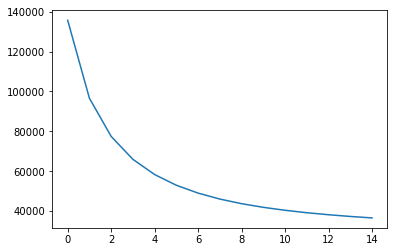

36579.3636429
done


In [18]:
## Stochasic GD without baseline score
# initialization
ite = 15                                  # number of iteration
lam = 0.2                                 # regulation factor: assume lam1 == lam2
mu = 0.005                                # study rate: assume mu1 == mu2
k = 20                                    # k is the number of concepts
m = user_id.__len__()                     # m is the number of users
n = business_id.__len__()                 # n is the number of restaurants
q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
p = np.random.rand(n, k) * sqrt(5.0 / k)
fig = empty(ite)

## essential steps
# 1. read the file to get user_id, business_id, stars
# 2. find the corresponding index of user_id, business_id in q and p
# 3. Stochastic GD alg
for num in range(0, ite):
    print num
    # read the file to update q & p
#     with open('yelp_data/yelp_testing.json') as f:
    with open('yelp_data/alg_train.json') as f:
        for line in f:
            temp = json.loads(line)
            i = user_match[temp["user_id"]]                  # get the index of corresponding user in q
            j = business_match[temp["business_id"]]          # get the index of corresponding business in p
            star = temp["stars"]
            # SGD without baseline
            eps = 2 * (star - dot(q[i, ], p[j, ]))
            temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
            temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
            q[i, ] = temp_q
            p[j, ] = temp_p
            
    # read the file to calculate the error
    error = 0
    RMSE = 0
#     with open('yelp_data/yelp_testing.json') as f:
    with open('yelp_data/alg_train.json') as f:
        for line in f:
            temp = json.loads(line)
            i = user_match[temp["user_id"]]
            j = business_match[temp["business_id"]]
            star = temp["stars"]
            error += (star - dot(q[i, ], p[j, ])) ** 2
    RMSE = error
    # add the regulation error (combine them in all)
    error += lam * (sum(q ** 2) + sum(p ** 2))
    fig[num] = error        

# examine: plot the graph 
plt.plot(range(0, ite), fig)
plt.show()            
print error 
print "done"

In [17]:
## testing: test data & train data are totally separated without baseline
size = 0
RMSE = 0
with open('yelp_data/alg_test.json') as f:
    for line in f:
        temp = json.loads(line)
        cur_user_id = temp["user_id"]
        cur_business_id = temp["business_id"]
        
        # check if current review is in the Matrix
        if cur_user_id in user_match and cur_business_id in business_match:
            size += 1
            i = user_match[cur_user_id]
            j = business_match[cur_business_id]
            star = temp["stars"]
            RMSE += (star - dot(q[i, ], p[j, ])) ** 2
    RMSE = sqrt(RMSE / float(size))    

print size
print RMSE
print "done"

4023
1.22837726259
done


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


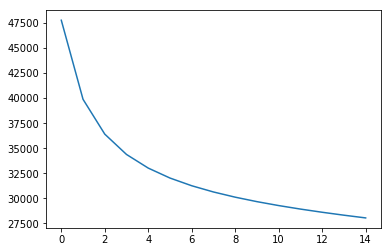

28045.2814426
done


In [23]:
## Stochasic GD with baseline score
# initialization
ite = 15                                  # number of iteration
lam = 0.2                                 # regulation factor: assume lam1 == lam2
mu = 0.005                                # study rate: assume mu1 == mu2
k = 20                                    # k is the number of concepts
m = user_id.__len__()                     # m is the number of users
n = business_id.__len__()                 # n is the number of restaurants
q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
p = np.random.rand(n, k) * sqrt(5.0 / k)
user_bias = dict(origin_user_bias)
business_bias = dict(origin_business_bias)
fig = empty(ite)

## essential steps
# 1. read the file to get user_id, business_id, stars
# 2. find the corresponding index of user_id, business_id in q and p
# 3. Stochastic GD alg
for num in range(0, ite):
    print num
    # read the file to update q & p
#     with open('yelp_data/yelp_testing.json') as f:
    with open('yelp_data/alg_train.json') as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            # get initialized b_x, b_i
            b_x = user_bias[cur_user_id]
            b_i = business_bias[cur_business_id]
            i = user_match[cur_user_id]                  # get the index of corresponding user in q
            j = business_match[cur_business_id]          # get the index of corresponding business in p
            star = temp["stars"]
            # updating p, q, b_x & b_i
            eps = 2 * (star - (average + b_x + b_i + dot(q[i, ], p[j, ])))
            temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
            temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
            q[i, ] = temp_q
            p[j, ] = temp_p
            user_bias[cur_user_id] = b_x + mu * (eps - 2 * lam * b_x)
            business_bias[cur_business_id] = b_i + mu * (eps - 2 * lam * b_i)
            
    # read the file to calculate the error
    error = 0
    with open('yelp_data/alg_train.json') as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            i = user_match[cur_user_id]
            j = business_match[cur_business_id]
            b_x = user_bias[cur_user_id]
            b_i = business_bias[cur_business_id] 
            star = temp["stars"]
            error += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
    # add the regulation error (combine them in all)
    # regulation for b_x & b_i
    regu_user_bias = 0
    regu_business_bias = 0
    for key in user_bias:
        regu_user_bias += user_bias[key] ** 2
    for key in business_bias:
        regu_business_bias += business_bias[key] ** 2
    error += lam * (sum(q ** 2) + sum(p ** 2) + regu_user_bias + regu_business_bias)
    fig[num] = error        

# examine: plot the graph 
plt.plot(range(0, ite), fig)
plt.show()            
print error             
print "done"

In [24]:
## testing: test data & train data are totally separated with baseline
extrapolate_star = []
origin_star = []
size = 0
RMSE = 0
with open('yelp_data/alg_test.json') as f:
    for line in f:
        temp = json.loads(line)
        cur_user_id = temp["user_id"]
        cur_business_id = temp["business_id"]
        
        # check if current review is in the Matrix
        if cur_user_id in user_match and cur_business_id in business_match:
            size += 1
            i = user_match[cur_user_id]
            j = business_match[cur_business_id]
            star = temp["stars"]
            b_x = user_bias[cur_user_id]
            b_i = business_bias[cur_business_id] 
            RMSE += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
    RMSE = sqrt(RMSE / float(size))    

print size
print RMSE

print "done"

4023
1.26196919823
done


In [91]:
## SGD training function interface
# inputs(10):
# ite: number of iteration
# lam: regulation factor: assume lam1 == lam2 == lam3 == lam4
# mu: study rate: assume mu1 = mu2
# k: number of concept in latent factor
# m: number of users
# n: number of items
# user_match: from user_id to index i
# business_match: from business_id to index j
# user_bias & business_bias: should equal to original user_bias & business_bias, whose values won't change
# outputs(4):
# latent factor q & p, updated user_bias & business_bias
def SGD_train(file_name, ite, lam, mu, k, m, n, user_match, business_match, user_bias, business_bias):
    # initialization
    q = np.random.rand(m, k) * sqrt(5.0 / k)  # normalization
    p = np.random.rand(n, k) * sqrt(5.0 / k)
    fig = empty(ite)

    ## essential steps
    # 1. read the file to get user_id, business_id, stars
    # 2. find the corresponding index of user_id, business_id in q and p
    # 3. Stochastic GD alg
    for num in range(0, ite):
        print num
        # read the file to update q & p
        with open(file_name) as f:
            for line in f:
                temp = json.loads(line)
                cur_user_id = temp["user_id"]
                cur_business_id = temp["business_id"]
                # get initialized b_x, b_i
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id]
                i = user_match[cur_user_id]                  # get the index of corresponding user in q
                j = business_match[cur_business_id]          # get the index of corresponding business in p
                star = temp["stars"]
                # updating p, q, b_x & b_i
                eps = 2 * (star - (average + b_x + b_i + dot(q[i, ], p[j, ])))
                temp_q = q[i, ] + mu * (eps * p[j, ] - 2 * lam * q[i, ])
                temp_p = p[j, ] + mu * (eps * q[i, ] - 2 * lam * p[j, ])
                q[i, ] = temp_q
                p[j, ] = temp_p
                user_bias[cur_user_id] = b_x + mu * (eps - 2 * lam * b_x)
                business_bias[cur_business_id] = b_i + mu * (eps - 2 * lam * b_i)
    
        # read the file to calculate the error
#         error = 0
#         with open(file_name) as f:
#             for line in f:
#                 temp = json.loads(line)
#                 cur_user_id = temp["user_id"]
#                 cur_business_id = temp["business_id"]
#                 i = user_match[cur_user_id]
#                 j = business_match[cur_business_id]
#                 b_x = user_bias[cur_user_id]
#                 b_i = business_bias[cur_business_id] 
#                 star = temp["stars"]
#                 error += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
#         # add the regulation error (combine them in all)
#         # regulation for b_x & b_i
#         regu_user_bias = 0
#         regu_business_bias = 0
#         for key in user_bias:
#             regu_user_bias += user_bias[key] ** 2
#         for key in business_bias:
#             regu_business_bias += business_bias[key] ** 2
#         error += lam * (sum(q ** 2) + sum(p ** 2) + regu_user_bias + regu_business_bias)
#         fig[num] = error        

#     # examine: plot the graph 
#     plt.plot(range(0, ite), fig)
#     plt.show()            
#     print error             
#     print "done"
    return p, q, user_bias, business_bias

In [93]:
## SGD testing function with baseline interface
# input(2):
# file_name
# user_match & business_match
# user_bias & business_bias
# output(1):
# RMSE
def SGD_test(file_name, user_match, business_match, user_bias, business_bias):
    extrapolate_star = []
    origin_star = []
    size = 0
    RMSE = 0
    with open(file_name) as f:
        for line in f:
            temp = json.loads(line)
            cur_user_id = temp["user_id"]
            cur_business_id = temp["business_id"]
            # check if current review is in the Matrix
            if cur_user_id in user_match and cur_business_id in business_match:
                size += 1
                i = user_match[cur_user_id]
                j = business_match[cur_business_id]
                star = temp["stars"]
                b_x = user_bias[cur_user_id]
                b_i = business_bias[cur_business_id] 
                RMSE += (star - (average + b_x + b_i + dot(q[i, ], p[j, ]))) ** 2
        RMSE = sqrt(RMSE / float(size))    
    return RMSE

In [83]:
## tuning parameter
ite = 15                                  
lam = [(x + 1) / float(10) for x in range(0, 9)]          # for turing purpose                     
mu = 0.005                                
k = 20                                    
m = user_id.__len__()                     
n = business_id.__len__()        
file_name = 'yelp_data/alg_train.json'

for cur_lam in lam:
    user_bias = origin_user_bias
    business_bias = origin_user_bias
    [p, q, user_bias, business_bias] = SGD_train(
        file_name, ite, cur_lam, mu, k, m, n, user_match, business_match, user_bias, business_bias, average)
    RMSE = SGD_test(file_name, user_match, business_match, user_bias, business_bias):
    
    
    
    

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


In [22]:
## the error for just using "average"
size = 0
RMSE = 0
with open('yelp_data/alg_test.json') as f:
    for line in f:
        temp = json.loads(line)
        cur_user_id = temp["user_id"]
        cur_business_id = temp["business_id"]
        
        # check if current review is in the Matrix
        if cur_user_id in user_match and cur_business_id in business_match:
            size += 1
            i = user_match[cur_user_id]
            j = business_match[cur_business_id]
            star = temp["stars"]
            b_x = origin_user_bias[cur_user_id]
            b_i = origin_business_bias[cur_business_id] 
            RMSE += (star - (average + b_x + b_i)) ** 2
#             RMSE += (star - average) ** 2
    RMSE = sqrt(RMSE / float(size))    

print size
print RMSE
print "done"

4023
1.29339996776
done


In [119]:
print business_bias

{u'FJyMLZc-ctJV4bHeu_AQ1A': -0.81208344560546508, u'bxUZorggwGDpU_liCTZazw': 0.10579396220943581, u'_APcAWIVRrkYIQfwGcOeww': -0.14697990142614389, u'tSiR_cl3GBrTZUbEvkZ2XA': -0.30293082885398048, u'NqikW1xl-mgpHzX1HNA-MQ': -0.069370773858553766, u'Iexv0Un2MfGEjHk8ejL8Ww': -0.041619112673208045, u'_toz5ca6UeEMm-ScLakofg': 0.07246627989931749, u'3tQO7AzHTicIWc6Efbw67w': -1.5514951068249525, u'QFHbUR4bY09yp2vO8QlICQ': -0.4902032369488481, u'0E4GXJs7Ra4oRtv6gQTs0w': -0.22219693693054973, u'1av_7zemoQnj8hWLY_J9Zw': -0.5595657237977727, u'Z0YtZBD_hvgeceLqiThPBw': -0.39440628390648647, u'YHWjW9GLcuNtnh_xdCSOeA': -0.10679162090310594, u'7gjYJ6leqm2IMJXNpKvIlw': -0.067612723001128777, u'mJYzopHZZEXVJJrsue34aQ': 0.051887307573967527, u'OKlXchOaMlv5F6LEdaeiow': -0.33332495078852381, u'8oSlQByXcv-QXcBPD8UfNw': -0.62628783494453044, u'cZW9pK9FDiyztTT1FCB-Lg': -0.60366915042197167, u'WvcM5J7FyArSo2cio8Bduw': -0.38641648463460815, u'dXI95VscrvdWu5qu6CjnWQ': -0.025339650396444383, u'AeebTxeuusoChR-RnV